In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [75]:
class spyGameEnv(gym.Env):
  def __init__(self, env_type = 'Deterministic', max_time = 100):
    self.env_type = env_type
    self.env_h = 6
    self.env_w = 6
    self.max_time = max_time
    self.observation_space = spaces.Discrete(self.env_h * self.env_w)
    self.action_space = spaces.Discrete(4)
    self.state = np.zeros((self.env_h, self.env_w))
    self.agent_pos = np.asarray([0, 0])
    self.prev_pos = np.asarray([0, 0])
    self.plus_pos = np.asarray([[5, 1],  [0, 4], [3, 5]])
    self.minus_pos = np.asarray([ [2, 1], [1, 2], [3, 2], [5, 2]])
    self.belle_pos = np.asarray([5, 5])
    self.timestep = 0
    self.reward = 0
    self.done = False
    self.flag = False
    self.agent_choice = ''


  def reset(self):
    self.observation_space = spaces.Discrete(self.env_h * self.env_w)
    self.action_space = spaces.Discrete(4)
    self.state = np.zeros((self.env_h, self.env_w))
    self.state[0, 0] = 1
    self.agent_pos = np.asarray([0, 0])
    self.prev_pos = np.asarray([0, 0])
    self.plus_pos = np.asarray([[5, 1], [0, 4], [3, 5]])
    self.minus_pos = np.asarray([ [2, 1], [1, 2], [3, 2], [5, 2]])
    self.belle_pos = np.asarray([5, 5])
    self.timestep = 0
    self.reward = 0
    self.done = False
    self.flag = False
    self.agent_choice = ''

    return self.state

  def up(self):
    self.agent_choice = 'up'
    if self.agent_pos not in (self.state[-1, :]):
      self.agent_pos[1] -= 1
    
    
  def down(self):
    self.agent_choice = 'down'
    if self.agent_pos not in (self.state[0, :]):
      self.agent_pos[1] += 1
   

  def left(self):
    self.agent_choice = 'left'
    if self.agent_pos not in (self.state[:, 0]):
      self.agent_pos[0] -= 1
   

  def right(self):
    self.agent_choice = 'right'
    if self.agent_pos not in (self.state[:, -1]):
      self.agent_pos[0] += 1
    

  def set_pos(self, action):
    if self.env_type == 'Deterministic':
      if action == 0:
        self.right()
      if action == 1:
        self.left()
      if action == 2:
        self.down()
      if action == 3:
        self.up()

    elif self.env_type == 'Stochastic':
      func = [self.right, self.left, self.down, self.up]
      if action == 0:
        random.choices(func, cum_weights= [70, 80, 90, 100], k = 1)[0]()
      if action == 1:
        random.choices(func, cum_weights= [10, 80, 90, 100], k = 1)[0]()
      if action == 2:
        random.choices(func, cum_weights= [10, 20, 90, 100], k = 1)[0]()
      if action == 3:
        random.choices(func, cum_weights= [10, 20, 30, 100], k = 1)[0]()


  def get_reward(self):

    if self.agent_pos in self.plus_pos:
      self.reward = 0.75
    elif self.agent_pos in self.minus_pos:
      self.reward = -1.5
    elif np.array_equal(self.agent_pos, self.prev_pos):
      self.reward = -0.5
    elif np.array_equal(self.agent_pos, self.belle_pos):
      self.reward = 20
      self.done = True
      self.flag = True
    else:
      self.reward = -0.25

  def step(self, action):
    if not self.done:
      self.reward = 0
      self.prev_pos = self.agent_pos
      self.set_pos(action)
      self.agent_pos = np.clip(self.agent_pos, 0, 5)
      self.get_reward()
      self.timestep += 1
      self.state = np.zeros((self.env_h, self.env_w))
      a = self.agent_pos[0]
      #print(a)
      b = self.agent_pos[1]
      #print(b)
      self.state[a, b] = 1
      #print(self.state)
      flat = self.state.flatten()
      observation = np.where(flat == 1)
      #print(observation)
      if self.timestep == 30:
        self.done = True
      return observation, self.reward, self.done, self.flag
       

  def render(self):
    plt.imshow(self.state)
    plt.show()



    


## SARSA - Deterministic

In [54]:
import math
class SARSA():

  def __init__(self, epsilon = 1, alpha = 0.2, gamma = 0.9, decay_rate = 0.003):
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.track_ep = []
    self.min_eps = 0.001
    self.max_eps = 1
    self.dr = decay_rate

  def get_q(self, env):
    action_size = env.action_space.n
    state_size = env.observation_space.n

    return np.zeros((state_size, action_size))

  def map_val(self, a):
    b = ((a + 2.1)/(self.epsilon + 2.1))*self.epsilon
    return b

  def get_eps(self, t, ep, a = 0.7, b = 0.5, c= 0.3):
    st_time = (t - a * ep)/(b * ep)
    plac = np.cosh(math.exp(-st_time))
    eps = self.epsilon - (1/plac + (t * c/ep))
    a = self.map_val(eps)
    

    b = self.min_eps + (self.max_eps - self.min_eps)*(np.exp(-self.dr * (ep- 1)))
    #self.track_ep.append(b)
    return b
  
  def get_action(self, state, a, Q, t, ep):
    thresh = np.random.uniform(0, 1)
    eps = self.get_eps(t+1, ep+1)
    #print('eps', eps)
    if thresh > eps:
      return np.argmax(Q[state, :]), eps
    else:
      return a.sample(), eps

  def compute_Q(self, env, Q, num_ep = 1000, max_step = 20):
    reward = 0
    rewards_all_ep = []
    ts_in_ep = []
    goal_reached = []
    done = False
    for ep in range(num_ep):
      t = 0
      obs = env.reset()
      state1 = np.where(obs == 1)
      #print(state1)
      act_1, _  = self.get_action(state1, env.action_space, Q, t, ep)
      rewards_current_ep = 0
      done = False
      #if (ep % 10) == 0:
        #print(ep)
        #print('eps', epsil)
        

      while not done:
        #env.render()

        state2, reward, done, flag = env.step(act_1)
        #print(reward)
        #print('Q' , Q)

        act_2, epsil = self.get_action(state2, env.action_space, Q, t, ep)
        pred = Q[state1, act_1]
        tet = reward * (self.gamma ** t)
        #print('reward at t', tet)
        dest = tet + self.gamma * Q[state2, act_2]
        Q[state1, act_1] += (self.alpha * (dest - pred))
        
        state1 = state2
        act_1 = act_2

        t +=1
        rewards_current_ep += tet
        
        if done:
          break
      self.track_ep.append(epsil)
      rewards_all_ep.append(rewards_current_ep)
      ts_in_ep.append(t)
      goal_reached.append(flag)

      

    plt.plot(rewards_all_ep)
    plt.title('Reward per Episode')
    return Q, rewards_all_ep, ts_in_ep, goal_reached

  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


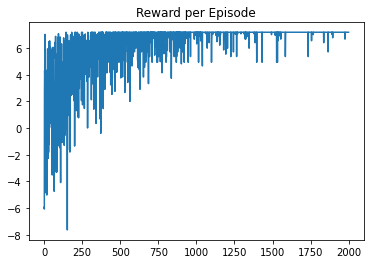

In [61]:
compute = SARSA()
env3 = spyGameEnv()
env3.reset()
Q1 = compute.get_q(env3)
Q1, reward, ts, gs = compute.compute_Q(env3, Q1, num_ep = 2000)

In [62]:
Q1

array([[ 1.72972219e+00,  2.14653499e+00,  2.22718234e+00,
         2.12327798e+00],
       [ 2.05527248e+00,  2.13474577e+00,  2.12878857e+00,
         2.20613354e+00],
       [ 1.45278935e+00,  2.05903286e+00,  2.07357407e+00,
         2.14875052e+00],
       [ 5.14778064e-01,  1.36219884e+00,  8.21290686e-01,
         2.18235230e+00],
       [ 4.38453794e-01,  4.77743717e-01,  4.06740043e-01,
         1.04431992e+00],
       [ 1.42906750e-01,  2.37829522e-01,  3.14063288e-01,
         5.10918538e-01],
       [ 1.01504554e+00,  2.38207616e+00,  1.93420493e+00,
         1.50061472e+00],
       [ 2.01137773e+00,  2.19531598e+00,  1.31056060e+00,
         1.53285695e+00],
       [ 3.71750266e-01,  2.18372913e+00,  5.01131807e-01,
         1.58408498e+00],
       [-4.96832527e-01,  1.35369014e+00,  4.48716449e-01,
         4.41211243e-01],
       [ 2.93943251e-01,  5.72324831e-01,  1.69591988e-01,
        -2.51821458e-01],
       [ 1.60114783e-01,  2.10920458e-01,  1.55382842e-01,
      

Text(0.5, 1.0, 'Epsilon Decay')

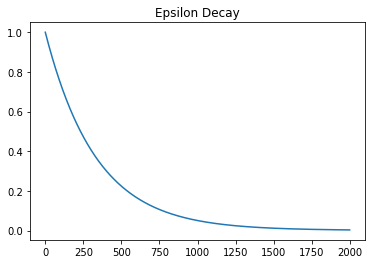

In [63]:
plt.plot(compute.track_ep)
plt.title('Epsilon Decay')

## Q Learning - Deterministic

In [64]:
import math
class Q_Learn():

  def __init__(self, epsilon = 0.9, alpha = 0.2, gamma = 0.7, decay_rate = 0.003):
    self.epsilon = epsilon
    self.alpha = alpha
    self.gamma = gamma
    self.track_ep = []
    self.min_eps = 0.001
    self.max_eps = 1
    self.dr = decay_rate

  def get_q(self, env):
    action_size = env.action_space.n
    state_size = env.observation_space.n

    return np.zeros((state_size, action_size))

  def map_val(self, a):
    b = ((a + 2.1)/(self.epsilon + 2.1))*self.epsilon
    return b

  def get_eps(self, t, ep, a = 0.7, b = 0.5, c= 0.3):
    st_time = (t - a * ep)/(b * ep)
    plac = np.cosh(math.exp(-st_time))
    eps = self.epsilon - (1/plac + (t * c/ep))
    a = self.map_val(eps)
    

    b = self.min_eps + (self.max_eps - self.min_eps)*(np.exp(-self.dr * (ep- 1)))
    #self.track_ep.append(b)
    return b
  
  def get_action(self, state, a, Q, t, ep):
    thresh = np.random.uniform(0, 1)
    eps = self.get_eps(t+1, ep+1)
    if thresh > eps:
      return np.argmax(Q[state, :]), eps
    else:
      return a.sample(), eps

  def compute_Q(self, env, Q, num_ep = 1000, max_step = 20):
    reward = 0
    rewards_all_ep = []
    ts_in_ep = []
    goal_reached = []
    done = False
    for ep in range(num_ep):
      t = 0
      obs = env.reset()
      state1 = np.where(obs == 1)
      act_1, _  = self.get_action(state1, env.action_space, Q, t, ep)
      rewards_current_ep = 0
      done = False
      #print(ep)

      while not done:
        #env.render()

        state2, reward, done, flag = env.step(act_1)
        act_2, epsil = self.get_action(state2, env.action_space, Q, t, ep)
        pred = Q[state1, act_1]
        tet = reward * (self.gamma ** t)
        dest = tet + self.gamma * np.max(Q[state2, :])
        Q[state1, act_1] += (self.alpha * (dest - pred))
        
        state1 = state2
        act_1 = act_2

        t +=1
        rewards_current_ep += tet
        
        if done:
          break
      self.track_ep.append(epsil)
      rewards_all_ep.append(rewards_current_ep)
      ts_in_ep.append(t)
      goal_reached.append(flag)
      

    plt.plot(rewards_all_ep)
    plt.title('Reward per Episode')
    return Q, rewards_all_ep, ts_in_ep, goal_reached

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


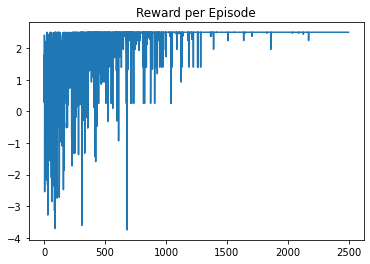

In [66]:
computen = Q_Learn()
env3n = spyGameEnv()
Q1n = computen.get_q(env3n)
Q1n, rewardn, tsn, gsn = computen.compute_Q(env3n, Q1n, num_ep = 2500)

In [67]:
Q1n

array([[ 8.45835288e-02,  1.75683685e-01,  1.81796510e-01,
         1.31374934e-01],
       [ 1.42204950e-01,  1.46580020e-01,  1.42608863e-01,
         1.75496738e-01],
       [ 4.99542051e-02,  1.51605202e-01,  1.46656096e-01,
         1.61076189e-01],
       [ 1.15258284e-01,  1.49634682e-01,  1.42157736e-01,
         1.46214287e-01],
       [ 6.58518640e-02,  6.98643128e-02,  3.71045778e-02,
         1.69603459e-01],
       [ 5.40917360e-03,  9.93999056e-03,  3.10783061e-04,
         9.27175777e-02],
       [-9.24194243e-02,  2.49635739e-01,  1.86360668e-01,
         1.47200420e-01],
       [ 1.42554195e-01,  1.76067677e-01, -9.01343827e-02,
         1.46784071e-01],
       [ 9.75778792e-02,  1.66802052e-01,  5.47461475e-02,
         1.93511564e-01],
       [ 5.19002351e-02,  1.65672369e-01,  6.16887213e-02,
         1.25869271e-01],
       [ 2.84636782e-03,  1.07284565e-01,  9.14338854e-03,
         1.33051418e-01],
       [ 7.23278415e-04,  1.85201654e-03,  1.01815264e-03,
      

Text(0.5, 1.0, 'Epsilon Decay')

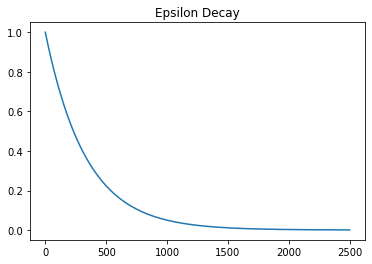

In [68]:
plt.plot(computen.track_ep)
plt.title('Epsilon Decay')

## SARSA - Stochastic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


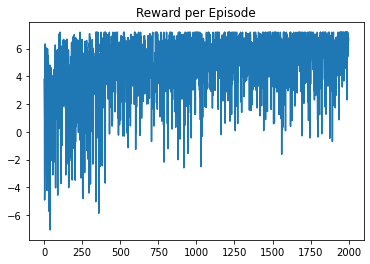

In [71]:
computes = SARSA()
env3s = spyGameEnv(env_type= 'Stochastic')
Q1s = compute.get_q(env3s)
Q1s, rewards, tss, gss = computes.compute_Q(env3s, Q1s, num_ep = 2000)

## Q Learning - Stochastic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


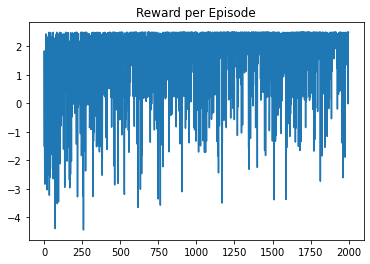

In [73]:
computens = Q_Learn()
env3ns = spyGameEnv(env_type= 'Stochastic')
Q1ns = computens.get_q(env3ns)
Q1ns, rewardns, tsns, gsns = computens.compute_Q(env3ns, Q1ns, num_ep = 2000)

## Hyper Parameter Variation - SARSA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


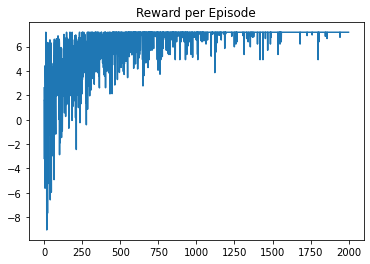

In [78]:
compute11 = SARSA(epsilon = 0.8)
env11 = spyGameEnv()
Q11 = compute.get_q(env11)
Q11, reward11, ts11, gs11 = compute11.compute_Q(env11, Q11, num_ep = 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


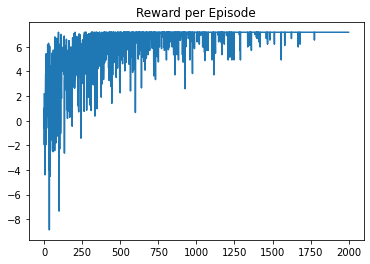

In [87]:
compute12 = SARSA(epsilon = 0.7)
env12 = spyGameEnv()
Q12 = compute.get_q(env12)
Q12, reward12, ts12, gs12 = compute12.compute_Q(env12, Q12, num_ep = 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


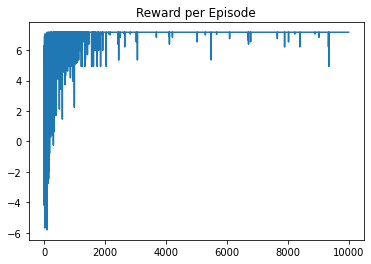

In [82]:
compute13 = SARSA(epsilon = 0.5)
env13 = spyGameEnv()
Q13 = compute.get_q(env13)
Q13, reward13, ts13, gs13 = compute13.compute_Q(env13, Q13, num_ep = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


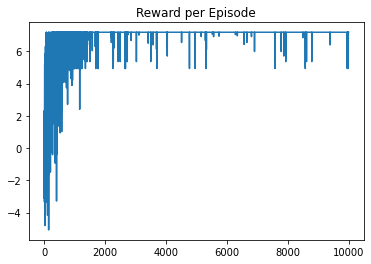

In [83]:
compute21 = SARSA(alpha = 0.75)
env21 = spyGameEnv()
Q21 = compute.get_q(env21)
Q21, reward21, ts21, gs21 = compute21.compute_Q(env21, Q21, num_ep = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


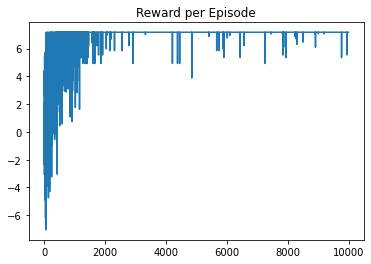

In [84]:
compute22 = SARSA(alpha = 0.95)
env22 = spyGameEnv()
Q22 = compute.get_q(env22)
Q22, reward22, ts22, gs22 = compute22.compute_Q(env22, Q22, num_ep = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


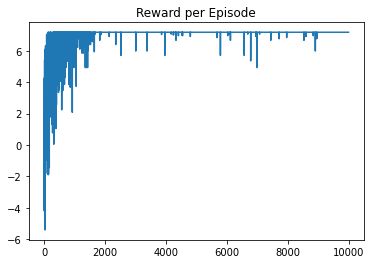

In [85]:
compute23 = SARSA(alpha = 0.05)
env23 = spyGameEnv()
Q23 = compute.get_q(env23)
Q23, reward23, ts23, gs23 = compute23.compute_Q(env23, Q23, num_ep = 10000)

# Q Learning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


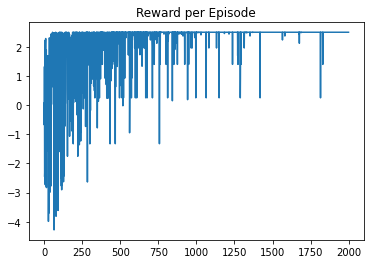

In [92]:
compute31 = Q_Learn(epsilon = 0.8)
env31 = spyGameEnv()
Q31 = compute.get_q(env31)
Q31, reward31, ts31, gs31 = compute31.compute_Q(env31, Q31, num_ep = 2000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


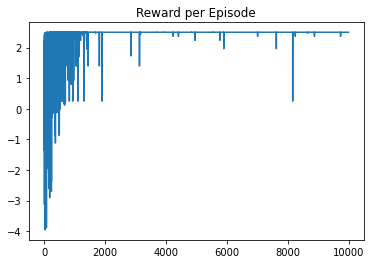

In [93]:
compute32 = Q_Learn(epsilon = 0.7)
env32 = spyGameEnv()
Q32 = compute.get_q(env32)
Q32, reward32, ts32, gs32 = compute32.compute_Q(env32, Q32, num_ep = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


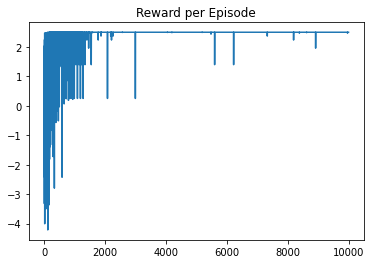

In [94]:
compute33 = Q_Learn(epsilon = 0.5)
env33 = spyGameEnv()
Q33 = compute.get_q(env33)
Q33, reward33, ts33, gs33 = compute33.compute_Q(env33, Q33, num_ep = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


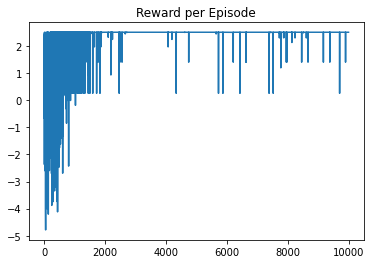

In [95]:
compute41 = Q_Learn(alpha = 0.75)
env41 = spyGameEnv()
Q41 = compute.get_q(env41)
Q41, reward41, ts41, gs41 = compute41.compute_Q(env41, Q41, num_ep = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


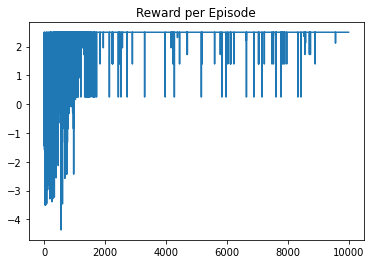

In [97]:
compute42 = Q_Learn(alpha = 0.95)
env42 = spyGameEnv()
Q42 = compute.get_q(env42)
Q42, reward42, ts42, gs42 = compute42.compute_Q(env42, Q42, num_ep = 10000)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


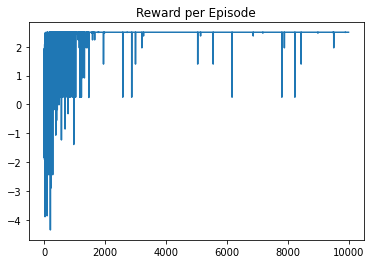

In [98]:
compute43 = Q_Learn(alpha = 0.05)
env43 = spyGameEnv()
Q43 = compute.get_q(env43)
Q43, reward43, ts43, gs43 = compute43.compute_Q(env43, Q43, num_ep = 10000)